In [133]:
import pandas as pd
import numpy as np

import torch
from tqdm import tqdm
# from tf2crf import CRF

# from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from skmultilearn.problem_transform import LabelPowerset
# from sklearn.multioutput import ClassifierChain

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, hamming_loss, f1_score
from sklearn.preprocessing import LabelEncoder

# from imblearn.over_sampling import SMOTE

from keras import layers
import keras
from keras.utils import to_categorical
from keras_preprocessing import sequence
from keras_preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

import seaborn as sns
# import xgboost as xgb
from sklearn.linear_model import LogisticRegression
# from skmultilearn.problem_transform import BinaryRelevance

from transformers import BertTokenizer, BertModel

from nltk.tokenize import word_tokenize
import os

import matplotlib.pyplot as plt

In [134]:
# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.13.0


In [153]:
data_path = os.path.join('data')
train_name = 'train_cleaned.csv'
train_cleaned = pd.read_csv(os.path.join(data_path, train_name), delimiter=',').dropna()

In [136]:
train_cleaned.head()

,text,label
0,kunjung prabowo resmi serah proyek bantu bersi...,Sumber Daya Alam
1,anies tepuk tangan riah rektor wajib kuliah ko...,Politik
2,bener dukung goblok dukung ridwan kamil skema ...,Demografi
3,anies sikap kritis kerja prabowo anggap engga ...,Politik
4,anies baswedan harap polri pegang sumpah milu,Politik


In [154]:
class_map={'Demografi':0, 'Ekonomi':1, 'Geografi':2, 'Ideologi':3, 'Pertahanan dan Keamanan':4,
          'Politik':5, 'Sosial Budaya':6, 'Sumber Daya Alam':7}

# Show number of different classes
n_classes = len(class_map)
print('Number of different classes: {}'.format(n_classes))

# Mapping the class names
train_cleaned['label'] = train_cleaned['label'].map(class_map)

Number of different classes: 8


In [155]:
train_cleaned[train_cleaned['label'] == 5].shape

(2969, 2)

In [164]:
# jumlah_hapus = 2500
# hapus_idx = train_cleaned[train_cleaned['label'] == 5].sample(n=jumlah_hapus, random_state=42).index
# train_cleaned = train_cleaned.drop(hapus_idx)


max_jumlah = 300

# Mengiterasi setiap kategori di label
for label in train_cleaned['label'].unique():
    jumlah_data = train_cleaned[train_cleaned['label'] == label].shape[0]
    if jumlah_data > max_jumlah:
        hapus_idx = train_cleaned[train_cleaned['label'] == label].sample(n=jumlah_data - max_jumlah, random_state=42).index
        train_cleaned = train_cleaned.drop(hapus_idx)

# Memverifikasi hasil
for label in train_cleaned['label'].unique():
    print(f"Label {label} memiliki {train_cleaned[train_cleaned['label'] == label].shape[0]} data.")

Label 7 memiliki 191 data.
Label 0 memiliki 62 data.
Label 5 memiliki 300 data.
Label 4 memiliki 300 data.
Label 6 memiliki 300 data.
Label 3 memiliki 300 data.
Label 1 memiliki 300 data.
Label 2 memiliki 18 data.


<Axes: xlabel='label'>

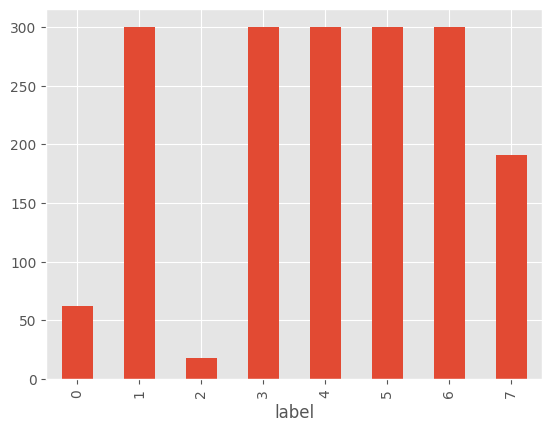

In [165]:
train_cleaned.groupby('label').size().plot(kind='bar')

In [166]:
dummy_columns = pd.get_dummies(train_cleaned['label'])
train_cleaned = pd.concat([train_cleaned, dummy_columns], axis=1).drop('label', axis=1).dropna()
train_cleaned.head()

,text,0,1,2,3,4,5,6,7
0,kunjung prabowo resmi serah proyek bantu bersi...,False,False,False,False,False,False,False,True
2,bener dukung goblok dukung ridwan kamil skema ...,True,False,False,False,False,False,False,False
7,anies allah sibuk orang zalim jahat orang zalim,False,False,False,False,False,True,False,False
11,ganjar pranowo mahfud tekan siap butuh dasar a...,False,False,False,False,True,False,False,False
12,calon presiden capres nomor anies baswedan mam...,False,False,False,False,True,False,False,False


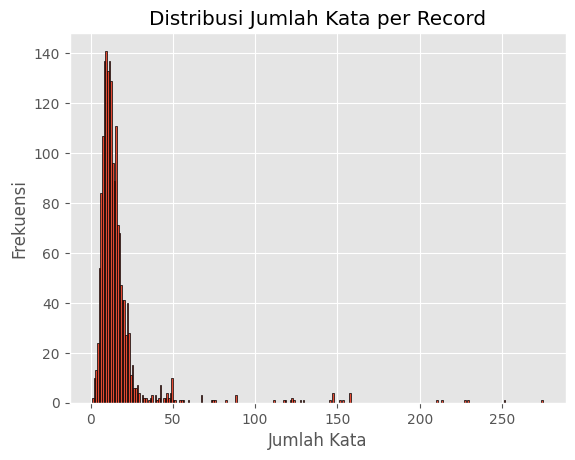

In [167]:
def count_words(text):
    return len(word_tokenize(text))

# Menghitung jumlah kata untuk setiap record
word_counts = [count_words(record) for record in train_cleaned['text']]

# Menampilkan histogram
plt.hist(word_counts, bins=range(1, max(word_counts) + 2), edgecolor='black')
plt.title('Distribusi Jumlah Kata per Record')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

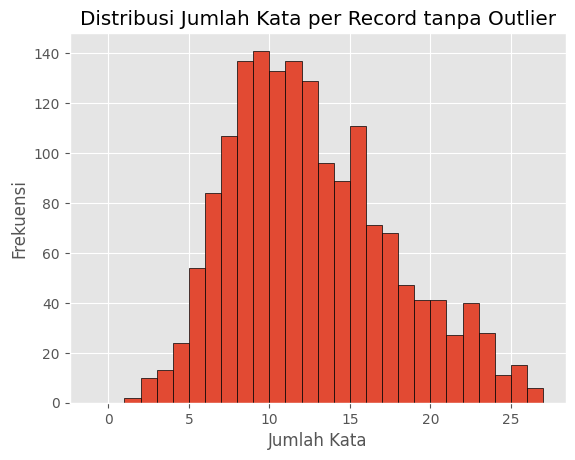

(1662, 9)


In [168]:
train_cleaned['word_count'] = train_cleaned['text'].apply(count_words)

# Menghitung Q1, Q3, dan IQR
Q1 = train_cleaned['word_count'].quantile(0.25)
Q3 = train_cleaned['word_count'].quantile(0.75)
IQR = Q3 - Q1

# Mendefinisikan batas bawah dan batas atas untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menghapus outlier
train_filtered = train_cleaned[(train_cleaned['word_count'] >= lower_bound) & (train_cleaned['word_count'] <= upper_bound)]

# Menampilkan histogram tanpa outlier
plt.hist(train_filtered['word_count'], bins=range(int(lower_bound), int(upper_bound) + 2), edgecolor='black')
plt.title('Distribusi Jumlah Kata per Record tanpa Outlier')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()
train_filtered = train_filtered.drop(columns=['word_count'], axis=1)
print(train_filtered.shape)

In [185]:
X = train_filtered['text'].values
y = train_filtered.iloc[:,1:].values
print(X.shape, y.shape)
indices = np.arange(X.shape[0])

# Split the data along with the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, indices, test_size=0.2, random_state=1, stratify=y
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1662,) (1662, 8)
(1329,) (1329, 8) (333,) (333, 8)


In [186]:
y_train_single = np.argmax(y_train, axis=1)
y_test_single = np.argmax(y_test, axis=1)

class_distribution_train = np.unique(y_train_single, return_counts=True)
class_distribution_test = np.unique(y_test_single, return_counts=True)
print(f'Sebaran Label Data Train: {class_distribution_train}')
print(f'Sebaran Label Data Test: {class_distribution_test}')


Sebaran Label Data Train: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 46, 223,  14, 225, 224, 234, 219, 144]))
Sebaran Label Data Test: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([12, 56,  4, 56, 56, 58, 55, 36]))


In [171]:
def baseline_ml_preprocessing(X_train,X_test):
    word_vectorizer = TfidfVectorizer(
        strip_accents='unicode',     
        analyzer='word',
        max_features=3000,        
        token_pattern=r'\w{1,}',    
        ngram_range=(1, 4),         
        # stop_words='indonesian',
        sublinear_tf=True)

    word_vectorizer.fit(X_train)
    ml_X_train = word_vectorizer.transform(X_train)
    ml_X_test = word_vectorizer.transform(X_test)
    return ml_X_train, ml_X_test

def Sequential_Preprocessing(X_train, X_test, y_train, y_test,max_seq_len):
    tokenizer = Tokenizer(num_words=40000,oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    X_train = torch.from_numpy(pad_sequences(X_train, maxlen=max_seq_len))
    X_test = torch.from_numpy(pad_sequences(X_test, maxlen=max_seq_len))

    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)

    return tokenizer, X_train, y_train, X_test, y_test


def get_bert_embedding_matrix(tokenizer):
    bert_model = BertModel.from_pretrained('indobenchmark/indobert-base-p1')
    bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
    vocab_size = len(tokenizer.index_word)+1
    bert_embedding_matrix = torch.zeros(vocab_size, 768)


    tokens_tensor=[]
    for i in tqdm(range(1, vocab_size)):
        word = tokenizer.index_word[i]
        tokens = bert_tokenizer.encode(word,add_special_tokens=False)[0]
        tokens_tensor.append(tokens)
    batch_size = 256
    vocab_batches = [tokens_tensor[i:i+batch_size] for i in range(0, len(tokens_tensor), batch_size)]

    with torch.no_grad():
      bert_embeddings = []
      for i in tqdm(range(len(vocab_batches))):
        batch = vocab_batches[i]
        inputs = {
        'input_ids': torch.tensor([batch]),
        'attention_mask': torch.ones(len(batch)).unsqueeze(0)
        }
        outputs = bert_model(**inputs)
        batch_embeddings = outputs[0][0]
        bert_embeddings.append(batch_embeddings)
        
    bert_embedding_matrix = torch.cat(bert_embeddings, dim=0)
    return bert_embedding_matrix


In [187]:
ml_X_train, ml_X_test = baseline_ml_preprocessing(X_train,X_test)
print("X_train shape for baseline models:",ml_X_train.shape)
print("X_test shape for baseline models:",ml_X_test.shape)

X_train shape for baseline models: (1329, 3000)
X_test shape for baseline models: (333, 3000)


In [188]:
scores_df = pd.DataFrame(columns=['model_name','micro_avg_f1_score','hamming_loss','accuracy'])

In [190]:
class HierarchicalSVM:
    def __init__(self):
        self.classifiers = {}#Dictionary to store the classifiers for each label

    def train(self, X_train, Y_train):
        num_labels = Y_train.shape[1]
        # Train the classifiers for each label
        for label_idx in range(num_labels):
            label = str(label_idx)
            Y_label = Y_train[:, label_idx]
            classifier = svm.SVC(kernel='linear')
            classifier.fit(X_train, Y_label)
            self.classifiers[label] = classifier

    def predict(self, X_test):
        num_labels = len(self.classifiers)
        num_samples = X_test.shape[0]
        predictions = np.zeros((num_samples, num_labels))
        for label_idx, classifier in self.classifiers.items():
            label_predictions = classifier.predict(X_test)
            predictions[:, int(label_idx)] = label_predictions
        return predictions

In [191]:
model = HierarchicalSVM()
model.train(ml_X_train, y_train)
y_pred = model.predict(ml_X_test)
print(classification_report(y_pred,y_test))
accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy Test: {accuracy}')
y_pred_t = model.predict(ml_X_train)
accuracy_t = accuracy_score(y_pred_t, y_train)
print(f'Accuracy Train: {accuracy_t}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.70      0.95      0.80        41
           2       0.00      0.00      0.00         0
           3       0.54      0.97      0.69        31
           4       0.73      0.95      0.83        43
           5       0.17      0.62      0.27        16
           6       0.40      0.73      0.52        30
           7       0.31      0.85      0.45        13

   micro avg       0.46      0.88      0.60       174
   macro avg       0.36      0.63      0.44       174
weighted avg       0.55      0.88      0.66       174
 samples avg       0.46      0.46      0.46       174

Accuracy Test: 0.4594594594594595
Accuracy Train: 0.6613995485327314


In [192]:
max_seq_len = 100
tokenizer, X_train, y_train, X_test, y_test = Sequential_Preprocessing(X_train, X_test, y_train, y_test,max_seq_len)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1329, 100]) torch.Size([333, 100]) torch.Size([1329, 8]) torch.Size([333, 8])


In [18]:
# y_train_single = np.argmax(y_train, axis=1)
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled_single = rus.fit_resample(X_train, y_train_single)
# y_resampled = to_categorical(y_resampled_single, num_classes=8)

In [19]:
# y_train_single = np.argmax(y_train, axis=1)
# smote = SMOTE(random_state=777, k_neighbors=5)
# X_smote, y_smote_single = smote.fit_resample(X_train, y_train_single)
# y_smote = to_categorical(y_smote_single, num_classes=8)

In [20]:
# unique_classes, counts = np.unique(y_smote_single, return_counts=True)

# # Plot the distribution
# plt.figure(figsize=(10, 6))
# plt.bar(unique_classes, counts, color='blue')
# plt.xlabel('Class')
# plt.ylabel('Frequency')
# plt.title('Distribution of Classes')
# plt.xticks(unique_classes) 
# plt.grid(axis='y')

# # Display the plot
# plt.show()

In [21]:
# print("Shapes after SMOTE resampling:")
# print(X_smote.shape, y_smote.shape)

In [173]:
bert_embeddding_matrix = get_bert_embedding_matrix(tokenizer)
print(bert_embeddding_matrix.shape)

100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


torch.Size([3079, 768])


In [23]:
# #Checking GPU for tensorflow
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.compat.v1.keras.backend.set_session(sess)
# print("GPU is Available? =>",tf.test.is_gpu_available())

In [174]:
VOCAB_SIZE = len(tokenizer.index_word)+1
bert_embd_mat= np.array(bert_embeddding_matrix.to('cpu').detach().numpy())
bert_embd_mat = np.vstack((np.zeros((1, bert_embd_mat.shape[1])), bert_embd_mat))

In [175]:
# Class weights
y_train_single = np.stack(y).argmax(axis=1)
classes = np.unique(y_train_single)
weights = compute_class_weight('balanced', classes=classes, y=y_train_single)
class_weights = {k: v for k, v in zip(classes, weights)}
print('Class weights:', class_weights)

Class weights: {0: 3.581896551724138, 1: 0.7446236559139785, 2: 11.541666666666666, 3: 0.7393238434163701, 4: 0.7419642857142857, 5: 0.711472602739726, 6: 0.7582116788321168, 7: 1.1541666666666666}


In [176]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='accuracy',  
    mode='max',          
    patience=0,          
    verbose=1,           
    baseline=0.98,       
    restore_best_weights=True  
)

In [27]:
# inp = Input(shape=(max_seq_len,))
# x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
# x = tf.keras.layers.Conv1D(filters=256, 
#                                    kernel_size=4,
#                                    activation='relu', 
#                                    kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(units=256, activation='relu',
#                             kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x_out = tf.keras.layers.Dense(8, activation='sigmoid')(x)
# model = tf.keras.models.Model(inputs=inp, outputs=x_out)

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # y_train_single = np.argmax(y_train, axis=1)
# history = model.fit(np.asarray(X_train), np.asarray(y_train), 
#                     batch_size=32, 
#                     epochs=20, 
#                     validation_split=0.2,
#                     class_weight=class_weights
#                     )
# class_weight=class_weights
# history = model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=32, epochs=16)
# y_pred = model.predict(np.asarray(X_test),batch_size=32, verbose=1)
# y_pred= np.where(y_pred > 0.5, 1, 0)

# accuracy = accuracy_score(y_pred, y_test)
# print(f'Accuracy: {accuracy}')

In [177]:
print("=====================Bert BiLSTM===========================")
inp = Input(shape=(max_seq_len,))
x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
# x = TimeDistributed(Dense(50, activation="relu"))(x)
# x = GlobalMaxPool1D()(x)
x = Dropout(0.4)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
# x = Dropout(0.1)(x)
# x = Dense(20, activation="gelu")(x)
# x = Dropout(0.1)(x)
x = Dense(8, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

# class_distribution = torch.sum(y_train, dim=0).float()
# total_samples = torch.sum(class_distribution)
# class_weights = total_samples / (len(class_distribution) * class_distribution)
# class_weights_np = class_weights.numpy()
# class_weight_dict = {i: class_weights_np[i] for i in range(len(class_weights_np))}

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
y_train_single = np.argmax(y_train, axis=1)

# Fit the model with early stopping
history = model.fit(
    np.asarray(X_train), np.asarray(y_train), 
    batch_size=32, 
    epochs=35, 
    validation_split=0.2,
    class_weight=class_weights,
    # callbacks=[early_stopping]  # Add the early stopping callback
)
# class_weight=class_weights
# history = model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=32, epochs=16)
y_pred = model.predict(np.asarray(X_test),batch_size=32, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

=====================Bert BiLSTM===========================
Epoch 1/35
34/34 [==============================] - 23s 492ms/step - loss: 0.3898 - accuracy: 0.1938 - val_loss: 0.3998 - val_accuracy: 0.2293
Epoch 2/35
34/34 [==============================] - 17s 493ms/step - loss: 0.3558 - accuracy: 0.2822 - val_loss: 0.4005 - val_accuracy: 0.4060
Epoch 3/35
34/34 [==============================] - 17s 492ms/step - loss: 0.3408 - accuracy: 0.4271 - val_loss: 0.3814 - val_accuracy: 0.3684
Epoch 4/35
34/34 [==============================] - 20s 598ms/step - loss: 0.3216 - accuracy: 0.4525 - val_loss: 0.3638 - val_accuracy: 0.4887
Epoch 5/35
34/34 [==============================] - 20s 594ms/step - loss: 0.3064 - accuracy: 0.5099 - val_loss: 0.3532 - val_accuracy: 0.5263
Epoch 6/35
34/34 [==============================] - 20s 587ms/step - loss: 0.2814 - accuracy: 0.5635 - val_loss: 0.3460 - val_accuracy: 0.5113
Epoch 7/35
34/34 [==============================] - 21s 617ms/step - loss: 0.2557 

In [179]:
y_pred = model.predict(np.asarray(X_test),batch_size=32, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

y_pred_t = model.predict(np.asarray(X_train),batch_size=32, verbose=1)
y_pred_t= np.where(y_pred_t > 0.5, 1, 0)

accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy Data Test: {accuracy}')

accuracy = accuracy_score(y_pred_t, y_train)
print(f'Accuracy Data Train: {accuracy}')

42/42 [==============================] - 4s 103ms/step
Accuracy Data Test: 0.5525525525525525
Accuracy Data Train: 0.8796087283671934


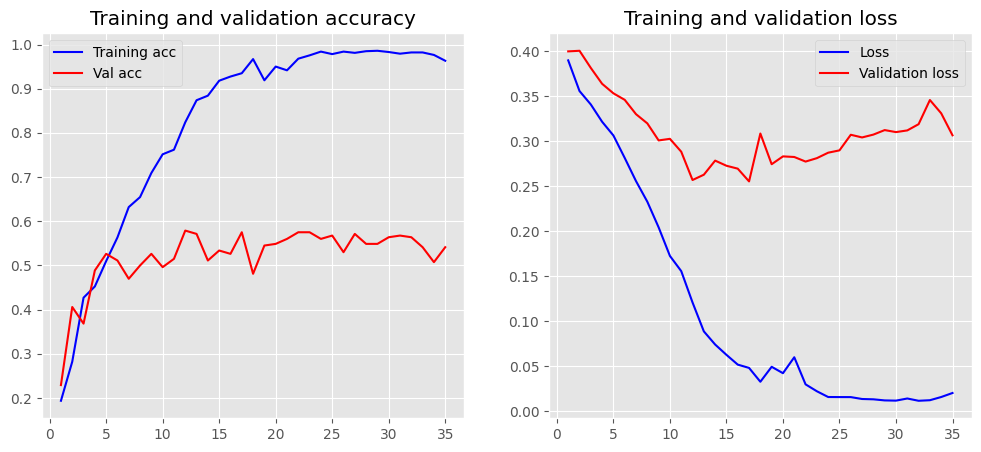

In [180]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Val acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x,loss, 'b', label='Loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [182]:
y_pred_single = np.argmax(y_pred, axis=1)
y_test_single = np.argmax(y_test, axis=1)

bert_cnn = pd.DataFrame({
    "text": X[test_indices],  
    "y_true": y_test_single,
    "y_pred": y_pred_single
})

# print(bert_cnn)
csv_file = "pred/bert-bilstm.xlsx"
bert_cnn.to_excel(os.path.join(data_path, csv_file), index=False)
print("Write CSV Done.")

Write CSV Done.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.25      0.08        12
           1       0.73      0.79      0.76        56
           2       0.00      0.00      0.00         4
           3       0.85      0.59      0.69        56
           4       0.84      0.64      0.73        56
           5       0.54      0.22      0.32        58
           6       0.68      0.71      0.70        55
           7       0.42      0.58      0.49        36

    accuracy                           0.57       333
   macro avg       0.51      0.47      0.47       333
weighted avg       0.66      0.57      0.59       333



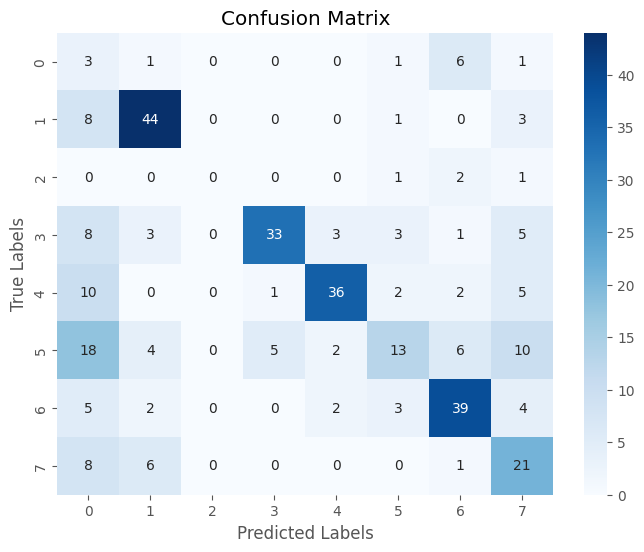

In [183]:
def evaluate_classification(data_true, data_predicted):
    # Print classification report
    report = classification_report(data_true, data_predicted)
    print("Classification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(data_true, data_predicted)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
evaluate_classification(y_test_single, y_pred_single)

In [95]:
print("=====================Bert CNN===========================")
inp = Input(shape=(max_seq_len,))

x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = layers.Conv1D(filters = 256, kernel_size=5,activation='relu')(x)
x = GlobalMaxPool1D()(x)
# x = MaxPooling1D(pool_size=2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(np.asarray(X_train),np.asarray(y_train),batch_size=64, epochs=25, class_weight=class_weights, validation_split=0.2)
y_pred = model.predict(np.asarray(X_test),batch_size=64, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

# arr={'model_name':'CNN_bert','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
# scores_df = scores_df.append(arr,ignore_index=True)
# print(scores_df)
print(classification_report(y_pred,y_test))
accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')


=====================Bert CNN===========================
Epoch 1/25
45/45 [==============================] - 8s 167ms/step - loss: 0.6950 - accuracy: 0.0977 - val_loss: 0.5592 - val_accuracy: 0.1070
Epoch 2/25
45/45 [==============================] - 7s 163ms/step - loss: 0.5093 - accuracy: 0.1283 - val_loss: 0.4084 - val_accuracy: 0.1225
Epoch 3/25
45/45 [==============================] - 7s 162ms/step - loss: 0.4127 - accuracy: 0.1467 - val_loss: 0.3858 - val_accuracy: 0.1254
Epoch 4/25
45/45 [==============================] - 8s 172ms/step - loss: 0.3893 - accuracy: 0.1583 - val_loss: 0.3911 - val_accuracy: 0.1014
Epoch 5/25
45/45 [==============================] - 7s 166ms/step - loss: 0.3668 - accuracy: 0.1735 - val_loss: 0.3612 - val_accuracy: 0.1817
Epoch 6/25
45/45 [==============================] - 7s 166ms/step - loss: 0.3477 - accuracy: 0.2264 - val_loss: 0.3645 - val_accuracy: 0.1930
Epoch 7/25
45/45 [==============================] - 8s 168ms/step - loss: 0.3190 - accuracy

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


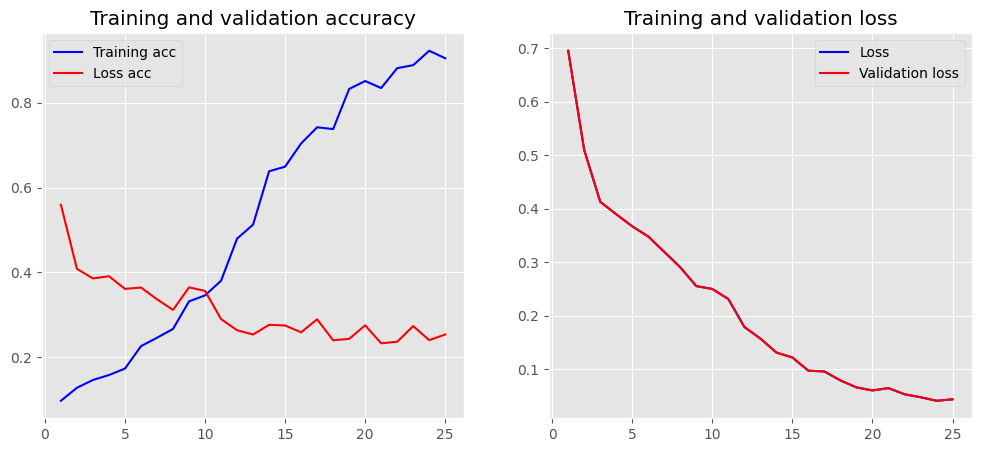

In [96]:
plot_history(history)

In [35]:
y_pred_single = np.argmax(y_pred, axis=1)
y_test_single = np.argmax(y_test, axis=1)

bert_cnn = pd.DataFrame({
    "text": X[test_indices],  
    "y_true": y_test_single,
    "y_pred": y_pred_single
})

# print(bert_cnn)
csv_file = "pred/bert-cnn.xlsx"
bert_cnn.to_excel(os.path.join(data_path, csv_file), index=False)
print("Write CSV Done.")

Write CSV Done.


Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.45      0.09        11
           1       0.61      0.64      0.62        69
           2       0.00      0.00      0.00         4
           3       0.65      0.52      0.58        75
           4       0.62      0.62      0.62        74
           5       0.80      0.76      0.78       570
           6       0.62      0.42      0.51       106
           7       0.43      0.28      0.34        36

    accuracy                           0.66       945
   macro avg       0.47      0.46      0.44       945
weighted avg       0.72      0.66      0.68       945



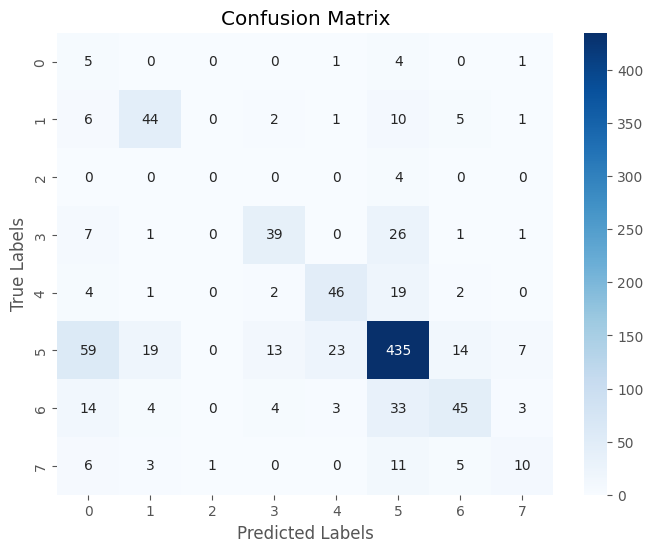

In [36]:
evaluate_classification(y_test_single, y_pred_single)

In [37]:
print("=====================Bert CNN-BiLSTM===========================")

inp = Input(shape=(max_seq_len,))

x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(100))(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

=====================Bert CNN-BiLSTM===========================


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 768)          6754560   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           73760     
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               106400    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 200)               0   

In [38]:
model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=16, epochs=10)
y_pred = model.predict(np.asarray(X_test),batch_size=8, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

# arr={'model_name':'CNN_bert','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
# scores_df = scores_df.append(arr,ignore_index=True)
# print(scores_df)
print(classification_report(y_pred,y_test))
accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Epoch 1/10
237/237 [==============================] - 11s 40ms/step - loss: 0.2754 - accuracy: 0.5958
Epoch 2/10
237/237 [==============================] - 9s 38ms/step - loss: 0.2311 - accuracy: 0.6294
Epoch 3/10
 59/237 [======>.......................] - ETA: 6s - loss: 0.1933 - accuracy: 0.6992

KeyboardInterrupt: 

In [ ]:
inp = Input(shape=(max_seq_len,))

x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(x)  # variational biLSTM
x = TimeDistributed(Dense(50, activation="relu"))(x)  # a dense layer as suggested by neuralNer
crf = CRF(8+1)  # CRF layer, n_tags+1(PAD)
out = crf(x)  # output

model = Model(inp, out)
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_134 (InputLayer)      [(None, 100)]             0         
                                                                 
 embedding_133 (Embedding)   (None, 100, 768)          9084672   
                                                                 
 bidirectional_53 (Bidirect  (None, 100, 100)          327600    
 ional)                                                          
                                                                 
 time_distributed_4 (TimeDi  (None, 100, 50)           5050      
 stributed)                                                      
                                                                 
 crf_3 (CRF)                 ((None, 100),             540       
                              (None, 100, 9),                    
                              (None,),                   